In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/gl_df.csv')
label = pd.read_csv('/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/label.csv')
df.head()

,발생일,규모,깊이(km),위도,경도
0,2017-03-09,2.0,22.0,35.82,129.78
1,2017-03-19,1.9,19.0,35.88,129.71
2,2017-04-15,3.1,13.0,36.11,129.36
3,2017-06-25,1.0,19.0,35.98,129.61
4,2017-09-11,1.9,5.0,36.10,129.35


In [ ]:
# 1. 데이터 시계열 변환

# (1) 날짜 형식 통일
if '발생일' in df.columns:
    df['발생일'] = pd.to_datetime(df['발생일'])
    df = df.set_index('발생일')

if '발생일' in label.columns:
    label['발생일'] = pd.to_datetime(label['발생일'])
    label = label.set_index('발생일')
elif not isinstance(label.index, pd.DatetimeIndex):
    label.index = pd.to_datetime(label.index)

# (2) 데이터 정렬
# label의 날짜를 기준으로 gl_df를 맞춤
gl_features = df.reindex(label.index)

# (3) 결측치 확인 및 채우기
print(gl_features.isnull().sum())

# 규모는 0.0으로, 나머지는 평균값으로 채움
gl_features['규모'] = gl_features['규모'].fillna(0.0)
for col in ['깊이(km)', '위도', '경도']:
    if col in gl_features.columns:
        mean_val = gl_features[col].mean()
        if pd.isna(mean_val): mean_val = 0.0
        gl_features[col] = gl_features[col].fillna(mean_val)

# label에도 NaN 확인 및 채우기
label['규모'] = label['규모'].fillna(0.0)

--- 결측치 점검 (채우기 전) ---
규모        365
깊이(km)    365
위도        365
경도        365
dtype: int64


In [ ]:
# 2. 윈도우 생성 (Sliding Window)
def create_dataset(X, y, window_size=3):
    X_list, y_mag_list = [], []

    for i in range(len(X) - window_size):
        # X: 과거 3일치의 데이터
        X_list.append(X[i : i+window_size])

        # y: 내일(i+window_size)의 지진 규모
        y_mag_list.append(y[i+window_size])

    return np.array(X_list), np.array(y_mag_list)

# 윈도우 사이즈 설정
WINDOW_SIZE = 3

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gl_features)

# y_values 정의
y_values = label['규모'].values

# X는 스케일링된 데이터, y는 label의 규모 값 사용
X_data, y_mag = create_dataset(X_scaled, y_values, WINDOW_SIZE)

# 분류용 정답 생성
y_class = (y_mag > 0).astype(int)

# 데이터 분할
X_train, X_test, yc_train, yc_test, ym_train, ym_test = train_test_split(
    X_data, y_class, y_mag,
    test_size=0.2,
    random_state=42,
    stratify=y_class # 지진 발생 비율 맞춰서 분할
)

print(f"\n최종 데이터: Train {len(X_train)}개 / Test {len(X_test)}개")


최종 데이터: Train 289개 / Test 73개


In [ ]:
# 1. 모델 초기화
tf.keras.backend.clear_session()

# 2. 모델 정의
def build_stable_model(input_shape):
    inputs = Input(shape=input_shape)

    # L2 규제 적용 (가중치 폭주 방지)
    x = Conv1D(filters=8, kernel_size=2, padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)

    # 공통 은닉층
    x = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

    # 이진 분류 (0 or 1)
    out_class = Dense(1, activation='sigmoid', name='classification')(x)

    # 회귀 (규모 예측)
    out_mag = Dense(1, activation='relu', name='regression')(x)

    model = Model(inputs=inputs, outputs=[out_class, out_mag])
    return model

model = build_stable_model(input_shape=(WINDOW_SIZE, 4))

# Gradient Clipping
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss={'classification': 'binary_crossentropy', 'regression': 'mse'},
              loss_weights={'classification': 0.5, 'regression': 1.0},
              metrics={'classification': 'accuracy', 'regression': 'mae'})


학습 시작...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

=== [최종 성능 평가] ===
분류 정확도: 86.30%
회귀 MSE: 0.3067

[예측값 상세 비교]
Sample 0: 실제 0.00 vs 예측 0.00
Sample 1: 실제 0.00 vs 예측 0.00
Sample 2: 실제 0.00 vs 예측 0.00
Sample 3: 실제 0.00 vs 예측 0.00
Sample 4: 실제 1.10 vs 예측 0.00
Sample 5: 실제 0.00 vs 예측 0.00
Sample 6: 실제 1.50 vs 예측 0.00
Sample 7: 실제 0.00 vs 예측 0.00
Sample 8: 실제 0.00 vs 예측 0.00
Sample 9: 실제 1.60 vs 예측 0.00
Sample 10: 실제 0.00 vs 예측 0.00
Sample 11: 실제 2.10 vs 예측 0.00
Sample 12: 실제 0.00 vs 예측 0.00
Sample 13: 실제 0.00 vs 예측 0.00
Sample 14: 실제 0.00 vs 예측 0.00
Sample 15: 실제 0.00 vs 예측 0.00
Sample 16: 실제 0.00 vs 예측 0.00
Sample 17: 실제 1.20 vs 예측 0.00
Sample 18: 실제 0.00 vs 예측 0.00
Sample 19: 실제 0.00 vs 예측 0.00
Sample 20: 실제 0.00 vs 예측 0.00
Sample 21: 실제 0.00 vs 예측 0.00
Sample 22: 실제 0.00 vs 예측 0.00
Sample 23: 실제 0.00 vs 예측 0.00
Sample 24: 실제 0.00 vs 예측 0.00
Sample 25: 실제 0.00 vs 예측 0.00
Sample 26: 실제 1.50 vs 예측 0.00
Sample 27: 실제 0.00 vs 예측 0.00
Sample 28: 실제 0.00 vs 예측 0.00
Sample 29: 실제 0.00 vs 예측 0.00

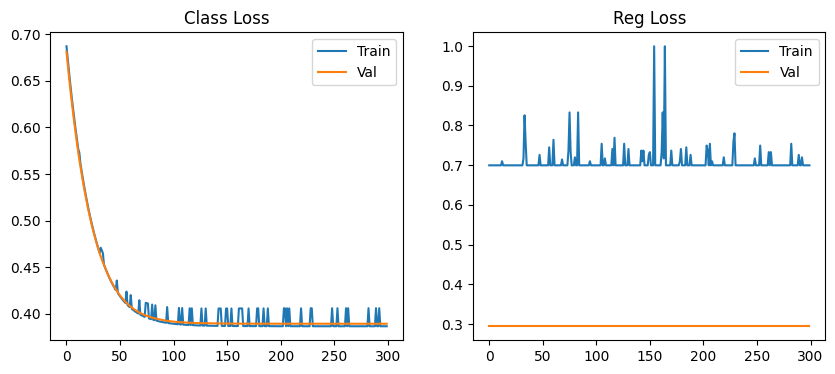

In [ ]:
# 4. 학습 및 평가
print("\n학습 시작...")
history = model.fit(
    X_train, [yc_train, ym_train],
    validation_data=(X_test, [yc_test, ym_test]),
    epochs=300,
    batch_size=4,
    verbose=0
)

# 5. 결과 확인
preds = model.predict(X_test)
pred_c = (preds[0] > 0.5).astype(int).flatten()
pred_m = preds[1].flatten()

# NaN 체크
if np.isnan(pred_m).any():
    print("여전히 NaN이 발생했습니다. 데이터 자체를 점검해야 합니다.")
    pred_m = np.nan_to_num(pred_m)

print("\n=== [최종 성능 평가] ===")
print(f"분류 정확도: {accuracy_score(yc_test, pred_c)*100:.2f}%")
print(f"회귀 MSE: {mean_squared_error(ym_test, pred_m):.4f}")

# 상세 비교 출력
print("\n[예측값 상세 비교]")
for i in range(len(yc_test)):
    print(f"Sample {i}: 실제 {ym_test[i]:.2f} vs 예측 {pred_m[i]:.2f}")

# 학습 곡선 확인
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.plot(history.history['classification_loss'], label='Train'); plt.plot(history.history['val_classification_loss'], label='Val'); plt.title('Class Loss'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(history.history['regression_loss'], label='Train'); plt.plot(history.history['val_regression_loss'], label='Val'); plt.title('Reg Loss'); plt.legend()
plt.show()

## 결과 시각화

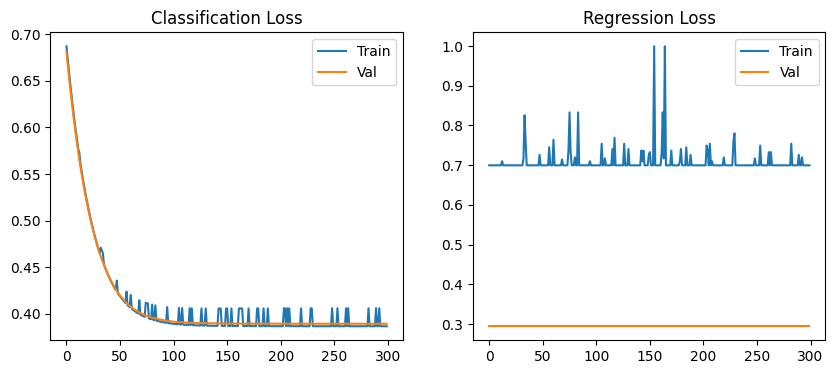

In [ ]:
# 결과 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_loss'], label='Train')
plt.plot(history.history['val_classification_loss'], label='Val')
plt.title('Classification Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['regression_loss'], label='Train')
plt.plot(history.history['val_regression_loss'], label='Val')
plt.title('Regression Loss')
plt.legend()
plt.show()